# Terrain classification in satellite images

This notebook demonstrates the use of neural networks to classify patches of satellite images in classes of terrain.

The dataset is the RGB version of EuroSAT, containing satelite images captured by Sentinel-2. It contains 27,000 patches labeled among 10 classes (see below). More info in https://github.com/phelber/eurosat

In this notebook we will demonstrate the training of a neural network model to classify satelite image patches. It assumes familiarity with the __1-Classifier-MNIST__ notebook, as its structure is identical.

## Import packages

We'll use
* time -- a standard Python library providing time related functions
* matplotlib for showing images -- more info in https://matplotlib.org/
* PyTorch is a machine learning library -- more info in https://pytorch.org/
  * torch.nn for using neural networks
  * torch.utils.data for loading datasets
  * torchvision.datasets for access to the EuroSAT dataset
  * torchvision.transforms for data transformation among images and tensors
  * torchvision.io for decoding images

In [2]:
%matplotlib widget

import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import *
from torchvision import datasets
from torchvision.transforms import *
from torchvision.io import decode_image

Determination of the AI acceleration device, if any.

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


## Dataset loading

Next we load the EuroSAT dataset and divide among train, test, and validation sets.

In [8]:
# Load EuroSAT dataset
full_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=ToTensor(),
)

dataset_size = len(full_dataset)
print(f"Loaded {dataset_size} samples from dataset.")

# Split the dataset
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset, [int(0.7*dataset_size),
                   int(0.15*dataset_size),
                   int(0.15*dataset_size)]
)

Loaded 27000 samples from dataset.


In [9]:
batch_size = 256

# Create data loaders.
train_dataloader      = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader       = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"  Training set: {len(train_dataset)} samples, {len(train_dataset)//batch_size} batches.")
print(f"Validation set: {len(validation_dataset)} samples, {len(validation_dataset)//batch_size} batches.")
print(f"      Test set: {len(test_dataset)} samples, {len(test_dataset)//batch_size} batches.")

Shape of X [N, C, H, W]: torch.Size([256, 3, 64, 64])
Shape of y: torch.Size([256]) torch.int64
  Training set: 18900 samples, 73 batches.
Validation set: 4050 samples, 15 batches.
      Test set: 4050 samples, 15 batches.


These are the labels used in the EuroSAT dataset:
0. Annual Crop
1. Forest
2. Herbaceous Vegetation
3. Highway
4. Industrial Buildings
5. Pasture
6. Permanent Crop
7. Residential Buildings
8. River
9. Sea & Lake

In [10]:
LABELS = ["A.Crop", "Forest", "Vegetation", "Highway", "Industrial", "Pasture", "P.Crop", "Residential", "River", "Sea/Lake"]

Here we show some examples from the three sets, one row per set: train, validation, and test. On top of each images is the label in the dataset (the groundtruth).

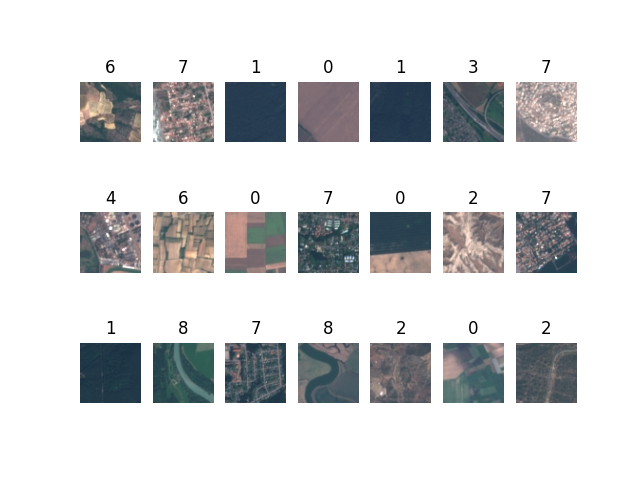

In [12]:
(fig,ax) = plt.subplots(3, 7)
for i,ds in enumerate([train_dataset, validation_dataset, test_dataset]):
    for j in range(7):
        ax[i,j].imshow(ds[j][0].permute(1,2,0))
        ax[i,j].set_axis_off()
        ax[i,j].set_title(ds[j][1])
plt.axis('off')
plt.show()

## Create a neural network model

Here we define some models to play with.

In [ ]:
class ClassicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #
            nn.Conv2d(48, 96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(96 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


In [ ]:
class BigCNN(SmallCNN):
    def __init__(self):
        super().__init__()
        self.cnn2 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(192 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 96 * 16 * 16),
            nn.ReLU(),
            nn.Dropout(0.25),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.cnn2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc2(x)
        x = self.fc(x)
        return x

In [ ]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 3x64x64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 64x32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 128x16x16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 256x8x8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 512x4x4
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 512x2x2
            nn.Flatten(),
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
            nn.Softmax(1))
        with torch.no_grad():
            self.apply(self.init_weights)

    def init_weights(self, m):
        if hasattr(m,"weight"):
            m.weight.normal_(std=1e-2)
        if hasattr(m,"bias"):
            m.bias.zero_()

    def forward(self, x):
        return self.net(x)


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 3x64x64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 64x32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 128x16x16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 256x8x8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 512x4x4
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 512x2x2
            nn.Flatten(),
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10),
            nn.Softmax(1))

    def forward(self, x):
        return self.net(x)


Selection of the model, the loss and the optimier.

In [18]:
## Uncomment the model you want to try out, leaving all others commented out

#model = ClassicNN().to(device)
model = SmallCNN().to(device)
#model = BigCNN().to(device)
#model = VGG11().to(device)

print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=5e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

SmallCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=24576, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Training the model

First we define a train and a test functions, identical to the ones in the __1_classifier-MNIST__ example.

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    t = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if time.monotonic()-t > 1:
            t = time.monotonic()
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

Perform the actual training for 20 epochs.

At each epoch, check the accuracy in the validation set, and keep the best one. This is a simple way of preventing overfitting.

In [20]:
epochs = 20
best_accuracy = None
t0 = time.monotonic()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    print("Validation: ", end="")
    accuracy = test(validation_dataloader, model, loss_fn)
    if best_accuracy is None or accuracy>best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()
dt = time.monotonic() - t0
print(f"Training done! ({dt} secs)")
model.load_state_dict(best_model)
print(f"Loaded best model in validation set: {(100*best_accuracy):>0.1f}%")
print("Test: ", end="")
test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.297020  [  256/18900]
loss: 2.243646  [ 1792/18900]
loss: 1.904211  [ 3584/18900]
loss: 1.745270  [ 5376/18900]
loss: 1.605182  [ 7168/18900]
loss: 1.402271  [ 8960/18900]
loss: 1.444688  [10752/18900]
loss: 1.376899  [12544/18900]
loss: 1.347163  [14336/18900]
loss: 1.279919  [16128/18900]
loss: 1.234821  [17920/18900]
Validation: Accuracy: 56.7%, Avg loss: 1.169179
Epoch 2
-------------------------------
loss: 1.113416  [  256/18900]
loss: 1.096568  [ 2304/18900]
loss: 1.148745  [ 4096/18900]
loss: 1.021444  [ 5888/18900]
loss: 1.030590  [ 7680/18900]
loss: 0.889528  [ 9472/18900]
loss: 1.045492  [11264/18900]
loss: 0.959779  [13056/18900]
loss: 1.020009  [14848/18900]
loss: 0.890357  [16640/18900]
loss: 0.740381  [18432/18900]
Validation: Accuracy: 68.7%, Avg loss: 0.884833
Epoch 3
-------------------------------
loss: 0.877397  [  256/18900]
loss: 0.875591  [ 2048/18900]
loss: 0.827501  [ 3840/18900]
loss: 0.883980  [ 5632/18900]
loss

0.8424691358024692

The following two cells can be used to save the model to disk or load it from disk.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
m = torch.load("model.pth")
model = BigCNN().to(device)
model.load_state_dict(m, strict=False)

## Testing the model

The next cell shows classification of some of the instances from the dataset.

As before, three rows are shown, one for each one of the train, validation, and test sets. At the top of each image, the first number is the __classification result__ and the second number, in paranthesis, is the __groundtruth__ (that is, the true value).

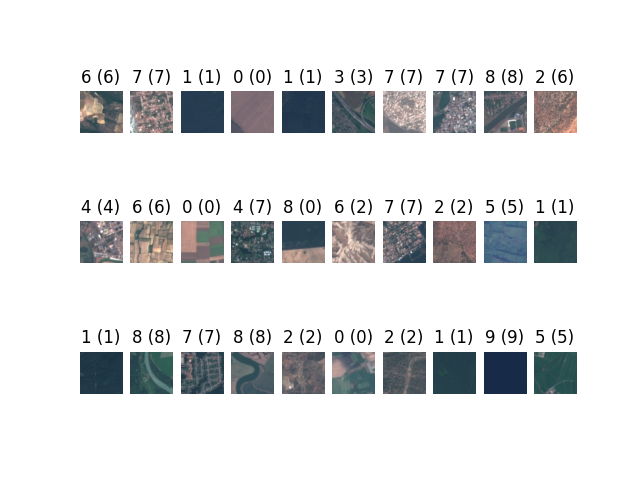

In [21]:
model.eval()
(fig,ax) = plt.subplots(3, 10)
for i,ds in enumerate([train_dataset, validation_dataset, test_dataset]):
    for j in range(10):
        x, y_gt = ds[j]
        x = x[None,:].to(device)
        y_out = model(x)
        pred = y_out[0].argmax(0)
        
        ax[i,j].imshow(ds[j][0].permute(1,2,0))
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f"{int(pred)} ({y_gt})")
plt.axis('off')
plt.show()

This is a custom dataset class that loads an image of arbitrary size and divides it into parches of tile_size by tile_size.

In [22]:
class ImageTilesDataset(Dataset):
    tile_size = 64
    
    def __init__(self, filename):
        self.image = decode_image(filename)
        if self.image.shape[0]>3:
            # HACK to get rid of extra channels
            self.image = self.image[:3]
        self.nrows = self.image.shape[1] // self.tile_size
        self.ncols = self.image.shape[2] // self.tile_size

    def get_tile(self, i, j):
        n = self.tile_size
        return self.image[:, (i*n):((i+1)*n), (j*n):((j+1)*n)].float()/256
    
    def __len__(self):
        return self.nrows*self.ncols

    def __getitem__(self, k):
        return self.get_tile(k//self.ncols, k%self.ncols)


In [ ]:
IMAGE_FILENAME = "data/Sentinel2/2025-03-29-00_00_2025-03-29-23_59_Sentinel-2_L1C_True_color.jpg"
#IMAGE_FILENAME = "data/Sentinel2/2025-03-19-00_00_2025-03-19-23_59_Sentinel-2_L1C_True_color.png"
#IMAGE_FILENAME = "data/Sentinel2/2025-04-11-00_00_2025-04-11-23_59_Sentinel-2_L1C_True_color.png"

image_dataset = ImageTilesDataset(IMAGE_FILENAME)

(fig,ax) = plt.subplots(5, 7)
for i in range(5):
    for j in range(7):
        ax[i,j].imshow(image_dataset.get_tile(i,j).permute(1,2,0))
        ax[i,j].set_axis_off()

In [ ]:
ds = image_dataset

out = torch.zeros([ds.nrows, ds.ncols])
for i in range(ds.nrows):
    for j in range(ds.ncols):
        tile = ds.get_tile(i, j)
        x = tile[None,:].to(device)
        y_out = model(x)
        pred = y_out[0].argmax(0)
        out[i,j] = int(pred)

(fig,ax) = plt.subplots(1, 2)
img = ax[1].imshow(out, cmap="plasma")
ax[1].set_axis_off()
ax[0].imshow(ds.image.permute(1,2,0))
ax[0].set_axis_off()

cbar = plt.colorbar(img)
cbar.ax.set_yticks(range(len(LABELS)))
cbar.ax.set_yticklabels(LABELS)

plt.show()
